In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
dataset_path = 'BankDataset/bank.csv'
df_tidy = pd.read_csv(dataset_path)

pd.set_option('display.max_columns', None)

In [ ]:
def compute_performance_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} F1 Score: {f1_score_value}")

def compute_classification_metric(dataset, predictions, label_name_v, favorable_label_v, unfavorable_label_v, privileged_attribute, unprivileged_attributes):
    features = [privileged_attribute] + unprivileged_attributes

    aif_sex_dataset = BinaryLabelDataset(
            df=dataset,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    aif_sex_pred = BinaryLabelDataset(
            df=predictions,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    sex_privileged_group = [{privileged_attribute: 1}]
    sex_unprivileged_groups = [{attr: 1} for attr in unprivileged_attributes]

    fairness_metrics = ClassificationMetric(dataset=aif_sex_dataset,
                            classified_dataset=aif_sex_pred,
                            unprivileged_groups=sex_unprivileged_groups,
                            privileged_groups=sex_privileged_group)
    
    return fairness_metrics

def compute_fairness_metrics(fairness_metrics: ClassificationMetric):
    # Values less than 0 indicate that privileged group has higher
    # proportion of predicted positive outcomes than unprivileged group.
    # Value higher than 0 indicates that unprivileged group has higher proportion
    # of predicted positive outcomes than privileged group.
    SPD = round(fairness_metrics.statistical_parity_difference(),3)

    # Measures the deviation from the equality of opportunity, which means that the same
    # proportion of each population receives the favorable outcome. This measure must be equal to 0 to be fair.
    EOD = round(fairness_metrics.equal_opportunity_difference(),3)

    # Average of difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups
    # A value of 0 indicates equality of odds, which means that samples in both the privileged and unprivileged
    # groups have the same probability of being classified positively.
    AOD = round(fairness_metrics.average_odds_difference(),3)

    print(f"Statistical Parity Difference (SPD): {SPD}")
    print(f"Equal Opportunity Difference (EOD): {EOD}")
    print(f"Average Odds Difference: {AOD}")

In [55]:
df_tidy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [56]:
print(df_tidy.shape)
df_tidy.info()

(11162, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [57]:
feature_num = df_tidy.select_dtypes(include=['int64', 'float'])
feature_num.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [58]:
feature_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       11162 non-null  int64
 1   balance   11162 non-null  int64
 2   day       11162 non-null  int64
 3   duration  11162 non-null  int64
 4   campaign  11162 non-null  int64
 5   pdays     11162 non-null  int64
 6   previous  11162 non-null  int64
dtypes: int64(7)
memory usage: 610.6 KB


In [59]:
categorize_age = lambda x: 'age<25' if x < 25 else ('25<=age<60' if x < 60 else 'age>=60')
df_tidy['age'] = df_tidy['age'].apply(categorize_age)
df_tidy.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,25<=age<60,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,25<=age<60,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,25<=age<60,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,25<=age<60,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,25<=age<60,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [60]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  object
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [61]:
#normalization extreme value smell
#scaler=MinMaxScaler()

#df_tidy[feature_num] = scaler.fit_transform(df_tidy[feature_num])


#df_tidy[['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]= scaler.fit_transform(df_tidy[['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']])

In [62]:
df_tidy[[ 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']].head()

,balance,day,duration,campaign,pdays,previous
0,2343,5,1042,1,-1,0
1,45,5,1467,1,-1,0
2,1270,5,1389,1,-1,0
3,2476,5,579,1,-1,0
4,184,5,673,2,-1,0


In [63]:
df_tidy['deposit'] = df_tidy['deposit'].replace({'yes': 1, 'no': 0})

C:\Users\abasi\AppData\Local\Temp\ipykernel_19996\1750454383.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tidy['deposit'] = df_tidy['deposit'].replace({'yes': 1, 'no': 0})


In [64]:
categorical_columns = ["age","job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
df_tidy = pd.get_dummies(df_tidy, columns=categorical_columns)
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343,5,1042,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,45,5,1467,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,1270,5,1389,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [65]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
df_tidy[numerical_cols].head()

,balance,day,duration,campaign,pdays,previous,deposit
0,2343,5,1042,1,-1,0,1
1,45,5,1467,1,-1,0,1
2,1270,5,1389,1,-1,0,1
3,2476,5,579,1,-1,0,1
4,184,5,673,2,-1,0,1


In [66]:
#df_raw.to_csv('BankDataset/bank2.csv', index=False)

In [67]:
numerical_cols = df_tidy.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('deposit')


# Inizializziamo lo StandardScaler
#scaler = MinMaxScaler()

# Applichiamo lo scaler solo alle colonne numeriche
#df_tidy[numerical_cols] = scaler.fit_transform(df_tidy[numerical_cols])

In [68]:
df_tidy[numerical_cols].head()

,balance,day,duration,campaign,pdays,previous
0,2343,5,1042,1,-1,0
1,45,5,1467,1,-1,0
2,1270,5,1389,1,-1,0
3,2476,5,579,1,-1,0
4,184,5,673,2,-1,0


In [69]:
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343,5,1042,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,45,5,1467,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,1270,5,1389,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


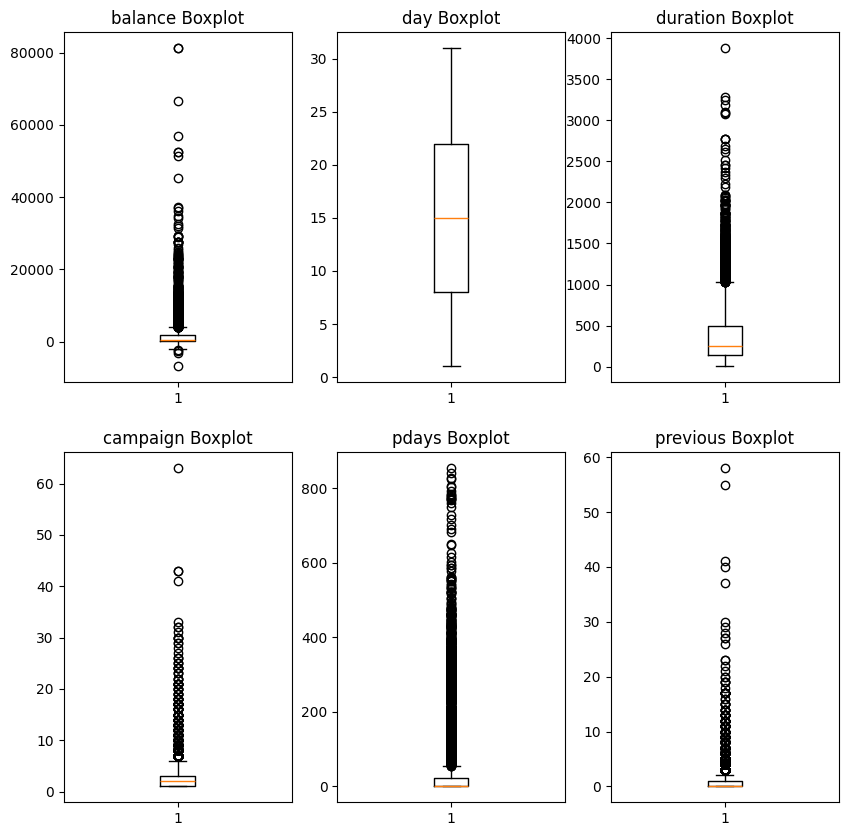

In [70]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [71]:
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343,5,1042,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,45,5,1467,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,1270,5,1389,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [72]:
def calculate_interquartil_interval(column_name):
    Q1 = df_tidy[column_name].quantile(0.25)
    Q3 = df_tidy[column_name].quantile(0.75)

    # Calcolo dell'intervallo interquartile (IQR)
    IQR = Q3 - Q1

    # Determinazione dei limiti inferiore e superiore per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def outliers_count_all(column_names):
    for column in column_names:
        lower_bound, upper_bound = calculate_interquartil_interval(column)
        outliers = df_tidy[(df_tidy[column] < lower_bound) | (df_tidy[column] > upper_bound)]
        print(f"numbers of outliers for {column} column: {outliers.shape[0]}")

def outliers_count(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    outliers = df_tidy[(df_tidy[column_name] < lower_bound) | (df_tidy[column_name] > upper_bound)]
    print(f"numbers of outliers for {column_name} column: {outliers.shape[0]}")

def delete_outlier(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    df_filtered = df_tidy[(df_tidy[column_name] >= lower_bound) & (df_tidy[column_name] <= upper_bound)]
    return df_filtered

In [73]:
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 1055
numbers of outliers for day column: 0
numbers of outliers for duration column: 636
numbers of outliers for campaign column: 601
numbers of outliers for pdays column: 2750
numbers of outliers for previous column: 1258


In [74]:
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2343,5,1042,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,45,5,1467,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,1270,5,1389,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [75]:
df_tidy = delete_outlier('balance')
df_tidy = delete_outlier('duration')
df_tidy = delete_outlier('campaign')
#df_tidy = delete_outlier('previous')

In [76]:
df_tidy.head()

,balance,day,duration,campaign,pdays,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3,2476,5,579,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,184,5,673,2,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
5,0,5,562,2,-1,0,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
8,1,6,608,1,-1,0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
10,100,7,786,1,-1,0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [77]:
df_tidy['pdays'].value_counts()

pdays
-1      6577
 181      38
 183      35
 182      35
 92       33
        ... 
 532       1
 481       1
 446       1
 470       1
 317       1
Name: count, Length: 380, dtype: int64

In [78]:
#df_tidy['pdays'] = np.sqrt(df_tidy['pdays']).astype('int64')
#df_tidy['pdays'] = df_tidy['pdays'].apply(lambda x: int(np.sqrt(x)))

#ci sono tanti valori negativi provo a droppare pdays
df_tidy= df_tidy.drop(columns=['pdays', 'previous'])

In [79]:
#numerical_cols= numerical_cols.drop('pdays')
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 515
numbers of outliers for day column: 0
numbers of outliers for duration column: 260
numbers of outliers for campaign column: 0


KeyError: 'pdays'

In [ ]:
df_tidy['balance'].value_counts()

balance
 0       606
 3        30
 1        29
 2        28
 5        25
        ... 
-198       1
 1332      1
 1657      1
 2729      1
 733       1
Name: count, Length: 2737, dtype: int64

In [ ]:
df_tidy['duration'].value_counts()


duration
97     33
161    31
136    30
144    30
114    30
       ..
791     1
900     1
713     1
800     1
914     1
Name: count, Length: 978, dtype: int64

In [ ]:
#df_tidy['previous'].value_counts()

previous
0    6577
1     761
2     585
Name: count, dtype: int64

In [ ]:
df_tidy['balance'] = np.sqrt(df_tidy['balance'])
df_tidy['duration'] = np.sqrt(df_tidy['duration'])
#df_tidy['previous'] = np.sqrt(df_tidy['previous'])

c:\Users\abasi\Desktop\Fairness_datasmell_SE4AI\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#df_tidy['balance'] = df_tidy['balance'].apply(lambda x: int(np.sqrt(x)))
#df_tidy['duration'] = df_tidy['duration'].apply(lambda x: int(np.sqrt(x)))
#df_tidy['previous'] = df_tidy['previous'].apply(lambda x: int(np.sqrt(x)))

In [ ]:
outliers_count_all(numerical_cols)

numbers of outliers for balance column: 0
numbers of outliers for day column: 0
numbers of outliers for duration column: 0
numbers of outliers for campaign column: 0
numbers of outliers for previous column: 1346


In [ ]:
#df_tidy['previous'].value_counts()

previous
0.000000    6577
1.000000     761
1.414214     585
Name: count, dtype: int64

In [ ]:
df_tidy['pdays'].value_counts()

pdays
0.000000    6576
0.461373      38
0.463902      35
0.462639      35
0.329806      33
            ... 
0.789552       1
0.750828       1
0.723054       1
0.742211       1
0.609860       1
Name: count, Length: 380, dtype: int64

In [ ]:
#columns_to_convert= ["previous"]
#for col in columns_to_convert:
    #if pd.api.types.is_float_dtype(df_tidy[columns_to_convert]):
        #df_tidy[columns_to_convert] = df_tidy[columns_to_convert].apply(lambda x: 0 if np.isclose(x, 0.0) else x)

In [ ]:
#df_tidy['previous'] = df_tidy['previous'].apply(lambda x:0 if x == 0.0 else x)

#if pd.api.types.is_float_dtype(df_tidy[colo]):
   # df_tidy[colo] = df_tidy[colo].apply(lambda x:0 if x == 0.0 else x)
#df_tidy[colo] = df_tidy[colo].applymap(lambda x: int(x) if x == 0.000000 else x)

#print(df_tidy)

In [ ]:
df_tidy.head()

,balance,day,duration,campaign,previous,deposit,age_25<=age<60,age_age<25,age_age>=60,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3,49.759421,5,24.062419,1,0.0,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,13.564660,5,25.942244,2,0.0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
5,0.000000,5,23.706539,2,0.0,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
8,1.000000,6,24.657656,1,0.0,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
10,10.000000,7,28.035692,1,0.0,1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [ ]:
df_tidy.to_csv('BankDataset/bank2.csv', index=False)

In [ ]:
X = df_tidy.drop(columns="deposit")
y = df_tidy["deposit"]

# Define four sets and apply the function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 0.2 indicates a test set size of 20%
                                                    random_state=42)

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42)

# The fit function will do the trick
dt_clf.fit(X_train, y_train)

# After the training phase, the model will be tested by predicting the values on the test set
dt_predictions = dt_clf.predict(X_test)

compute_performance_metrics(y_test,dt_predictions,"Decision Tree")

Decision Tree Accuracy: 0.7924290220820189
Decision Tree Recall: 0.7195301027900147
Decision Tree F1 Score: 0.7486631016042781


In [ ]:
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Addestra il classificatore sui dati di training
svm_classifier.fit(X_train, y_train)

# Fai delle predizioni sui dati di test
svm_pred = svm_classifier.predict(X_test)

compute_performance_metrics(y_test,svm_pred,"SVM")

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth = None, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

compute_performance_metrics(y_test,rf_predictions,"Random Forest")

Random Forest Accuracy: 0.8460567823343849
Random Forest Recall: 0.8323615160349854
Random Forest F1 Score: 0.823953823953824


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO IL DECISION TREE
dataset = X_test.copy(deep=True) # we create a copy of the test set
dataset['deposit'] = y_test  # and join the target feature with the others
predictions = dataset.copy(deep=True) # we do the same task
predictions['deposit'] = dt_predictions # but this time the target feature is made by the predictions of our model

In [ ]:
#Attributo privilegiato la colonna age tra 25 e 59
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.391
Equal Opportunity Difference (EOD): 0.136
Average Odds Difference: 0.256


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO L'SVM
dataset = X_test.copy(deep=True)
dataset['deposit'] = y_test
predictions = dataset.copy(deep=True) 
predictions['deposit'] = svm_pred

In [ ]:
#Attributo privilegiato la colonna age tra 25 e 59
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.405
Equal Opportunity Difference (EOD): 0.146
Average Odds Difference: 0.225


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO Il Random Forest
dataset = X_test.copy(deep=True)
dataset['deposit'] = y_test
predictions = dataset.copy(deep=True) 
predictions['deposit'] = rf_predictions

In [ ]:
#Attributo non privilegiato la colonna minore di 24 e maggiore di 59
# Valore favorevole 1
# Valore non favorevole 0

unprivileged_attributes = ["age_age<25", "age_age>=60"]
fairness_metrics = compute_classification_metric(dataset,predictions,"deposit",1,0,"age_25<=age<60",unprivileged_attributes) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): 0.412
Equal Opportunity Difference (EOD): 0.132
Average Odds Difference: 0.214
